# 라이브러리 불러오기

In [101]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# 데이터 읽어오기

In [102]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
submission = pd.read_csv("../input/gender_submission.csv")

In [103]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [105]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# 전처리 & 피처엔지니어링

In [106]:
all_data = pd.concat([train, test], sort = False)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [107]:
# Age, Fare의 null 값을 중앙값으로 치환
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

In [108]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


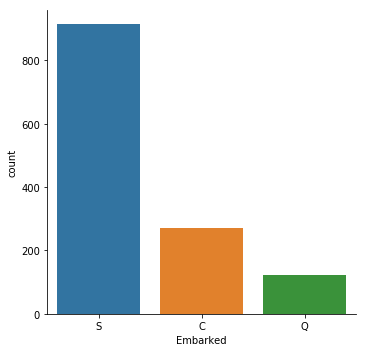

In [109]:
sns.catplot(x='Embarked', kind='count', data=all_data);

In [110]:
# Embarked 중 가장 많은 'S'로 null 값 치환
all_data['Embarked'] = all_data['Embarked'].fillna('S')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 172.9+ KB


In [111]:
# 나이 feature 구간 나누기
all_data.loc[all_data['Age'] <= 15, 'Age'] = 0
all_data.loc[(all_data['Age'] > 15) & (all_data['Age'] <= 25), 'Age'] = 1
all_data.loc[(all_data['Age'] > 25) & (all_data['Age'] <= 35), 'Age'] = 2
all_data.loc[(all_data['Age'] > 35) & (all_data['Age'] <= 45), 'Age'] = 3
all_data.loc[(all_data['Age'] > 45) & (all_data['Age'] <= 60), 'Age'] = 4
all_data.loc[ all_data['Age'] > 60, 'Age'] = 5

In [112]:
# Title 추출 함수
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+\.)', name)
    
    if title_search:
        return title_search.group(1)
    return ""

In [113]:
# Title 추출
all_data['Title'] = all_data['Name'].apply(get_title)
all_data['Title'].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Major.         2
Mlle.          2
Ms.            2
Capt.          1
Countess.      1
Mme.           1
Don.           1
Sir.           1
Jonkheer.      1
Lady.          1
Dona.          1
Name: Title, dtype: int64

In [114]:
# Title을 대표 Title로 축소
all_data['Title'] = all_data['Title'].replace(['Capt.', 'Dr.', 'Major.', 'Rev.'], 'Officer.')
all_data['Title'] = all_data['Title'].replace(['Lady.', 'Countess.', 'Don.', 'Sir.', 'Jonkheer.', 'Dona.'], 'Royal.')
all_data['Title'] = all_data['Title'].replace(['Mlle.', 'Ms.'], 'Miss.')
all_data['Title'] = all_data['Title'].replace(['Mme.'], 'Mrs.')
all_data['Title'].value_counts()

Mr.         757
Miss.       264
Mrs.        198
Master.      61
Officer.     19
Royal.        6
Col.          4
Name: Title, dtype: int64

In [115]:
# Cabin null값 처리
all_data['Cabin'] = all_data['Cabin'].fillna('Missing')
all_data['Cabin'] = all_data['Cabin'].str[0]
all_data['Cabin'].value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [116]:
# 가족 수 및 혼자사는지 여부에 대한 feature 추가
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = 0
all_data.loc[all_data['Family_Size']==1, 'IsAlone'] = 1
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,M,S,Mr.,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,71.2833,C,C,Mrs.,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,M,S,Miss.,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C,S,Mrs.,2,0
4,5,0.0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,M,S,Mr.,1,1


In [117]:
# 모델링에 필요 없는 feature 삭제
all_data.drop(['Name', 'Ticket'], axis=1, inplace=True)
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_Size,IsAlone
0,1,0.0,3,male,1.0,1,0,7.2500,M,S,Mr.,2,0
1,2,1.0,1,female,3.0,1,0,71.2833,C,C,Mrs.,2,0
2,3,1.0,3,female,2.0,0,0,7.9250,M,S,Miss.,1,1
3,4,1.0,1,female,2.0,1,0,53.1000,C,S,Mrs.,2,0
4,5,0.0,3,male,2.0,0,0,8.0500,M,S,Mr.,1,1


In [118]:
# 범주형 feature 가변수화하기
all_dummies = pd.get_dummies(all_data, drop_first=True)
all_dummies.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,IsAlone,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Officer.,Title_Royal.
0,1,0.0,3,1.0,1,0,7.2500,2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,2,1.0,1,3.0,1,0,71.2833,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,1.0,3,2.0,0,0,7.9250,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,4,1.0,1,2.0,1,0,53.1000,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,0.0,3,2.0,0,0,8.0500,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [119]:
train = all_dummies[all_dummies['Survived'].notna()]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId       891 non-null int64
Survived          891 non-null float64
Pclass            891 non-null int64
Age               891 non-null float64
SibSp             891 non-null int64
Parch             891 non-null int64
Fare              891 non-null float64
Family_Size       891 non-null int64
IsAlone           891 non-null int64
Sex_male          891 non-null uint8
Cabin_B           891 non-null uint8
Cabin_C           891 non-null uint8
Cabin_D           891 non-null uint8
Cabin_E           891 non-null uint8
Cabin_F           891 non-null uint8
Cabin_G           891 non-null uint8
Cabin_M           891 non-null uint8
Cabin_T           891 non-null uint8
Embarked_Q        891 non-null uint8
Embarked_S        891 non-null uint8
Title_Master.     891 non-null uint8
Title_Miss.       891 non-null uint8
Title_Mr.         891 non-null uint8
Title_Mrs.        891 non-null uint8
T

In [120]:
test = all_dummies[all_dummies['Survived'].isna()]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 26 columns):
PassengerId       418 non-null int64
Survived          0 non-null float64
Pclass            418 non-null int64
Age               418 non-null float64
SibSp             418 non-null int64
Parch             418 non-null int64
Fare              418 non-null float64
Family_Size       418 non-null int64
IsAlone           418 non-null int64
Sex_male          418 non-null uint8
Cabin_B           418 non-null uint8
Cabin_C           418 non-null uint8
Cabin_D           418 non-null uint8
Cabin_E           418 non-null uint8
Cabin_F           418 non-null uint8
Cabin_G           418 non-null uint8
Cabin_M           418 non-null uint8
Cabin_T           418 non-null uint8
Embarked_Q        418 non-null uint8
Embarked_S        418 non-null uint8
Title_Master.     418 non-null uint8
Title_Miss.       418 non-null uint8
Title_Mr.         418 non-null uint8
Title_Mrs.        418 non-null uint8
Tit

# 모델링 및 훈련/예측

In [121]:
X = train.drop(['PassengerId','Survived'], axis=1)
y = train['Survived']

test = test.drop(['PassengerId', 'Survived'], axis=1)

In [122]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=42)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [123]:
pred = clf.predict(test).astype(int)
submission['Survived'] = pred

In [124]:
submission.to_csv("submission.csv", index=False)